# Import Required Packages

# Import DPU Overlay and Loading the .xmodel

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import mnist_reader

In [27]:
#Type your code here

#Import the DPU Overlay and load the .xmodel
from pynq_dpu import DpuOverlay 
overlay = DpuOverlay("dpu.bit")
overlay.load_model("quantized_model.xmodel") 




# Loading the Fashion MNIST Dataset

In [28]:
fashion_mnist_labels = ["T-shirt/top", 
                            "Trouser",
                            "Pullover",
                            "Dress",
                            "Coat",
                            "Sandal", 
                            "Shirt",
                            "Sneaker",
                            "Bag",
                            "Ankle boot"]

In [29]:
#Type your code here

path_to_data = 'data/fashion'

x_test, y_test = mnist_reader.load_mnist(path_to_data, kind='t10k')
x_test = x_test.astype('float32')/255 #Convert the data type to float32 and perform feature scaling


print("Total number of test images: {}".format(x_test.shape[0]))
print("Shape of each image: {}".format(x_test.shape[1:]))


Total number of test images: 10000
Shape of each image: (784,)


# Running the Quantized Model

In [30]:
#Type your code here

dpu_runner = overlay.runner #Access the Runner object

inputTensors = dpu_runner.get_input_tensors() #Get input tensor
outputTensors = dpu_runner.get_output_tensors() #Get output tensor

shapeIn = inputTensors[0].dims #Get input tensor shape
shapeOut = outputTensors[0].dims #Get output tensor shape

print('Input shape:', shapeIn)
print('Output shape:', shapeOut)

Input shape: [1, 28, 28, 1]
Output shape: [1, 10]


In [31]:
input_data = x_test[0].reshape(shapeIn)
output_data = np.empty(shapeOut, dtype=np.float32)
job_id = dpu_runner.execute_async(input_data, output_data)
dpu_runner.wait(job_id)
print(output_data)

[[-14.   -5.  -11.   -7.5  -3.   -2.  -12.5   3.5  -5.    9.5]]


In [32]:
fashion_mnist_labels[output_data.ravel().argmax()]

'Ankle boot'

In [34]:
#Type your code here

num_pics = x_test.shape[0] #Number of images in the test set
prediction = np.zeros(num_pics, dtype=np.int8)    #Initiate a np.zeros() array to store the predicted class index
output_data = np.empty(shapeOut, dtype=np.float32) #Initiate an np.empty() array to store the FPGA output

#A for loop to loop through the images and make predictions
for i in tqdm(range(num_pics)):
    input_data = x_test[i].reshape(shapeIn)   #The input image, reshape it to shapeIn
    job_id = dpu_runner.execute_async(input_data, output_data)   #Make a prediction by calling execute_async()
    dpu_runner.wait(job_id) #Wait until the job is complete
    score = output_data.ravel()   #Flatten the output_data using .ravel()
    prediction[i] = score.argmax()   #Find the index of maximum score as our prediction, using .argmax()
    
print('accuracy:', np.mean(prediction == y_test))

100%|██████████| 10000/10000 [00:07<00:00, 1413.78it/s]

accuracy: 0.9166


# Timing Operations

In [35]:
input_data = x_test[0].reshape(shapeIn)
output_data = np.empty(shapeOut, dtype=np.float32)

In [37]:
%%timeit -o -r 1000 -n 1 -q

#Type your code here
job_id = dpu_runner.execute_async(input_data, output_data) #Make a prediction and time it, remember to call the .wait() method
dpu_runner.wait(job_id)

<TimeitResult : 1 loop, best of 1000: 650 µs per loop>

In [38]:
#Calculate the Frame Rate in Frames Per Second(FPS)
result = _
print('FPS:',1/np.mean(result.all_runs))

FPS: 1518.0210533599904


# Plotting the Result

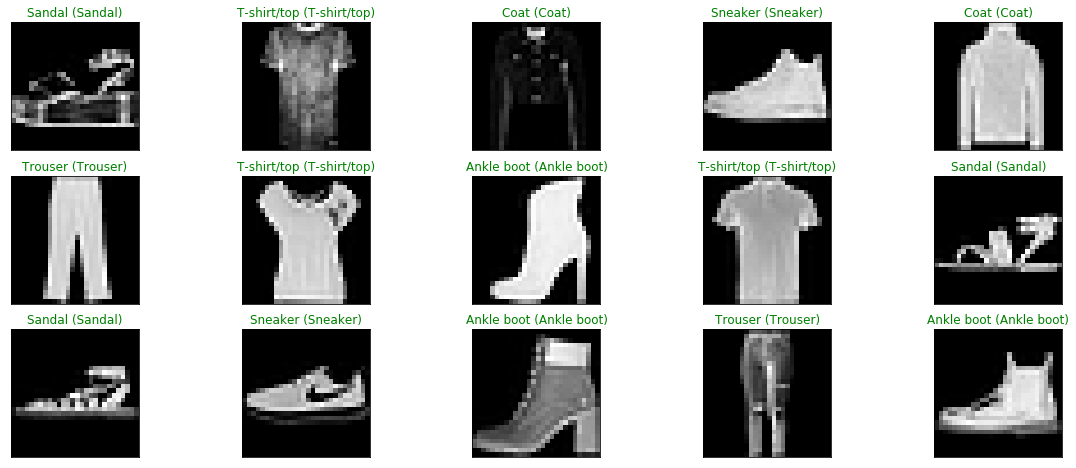

In [39]:
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(x_test[index].reshape(28,28), cmap='gray')
    predict_index = prediction[index]
    true_index = y_test[index]
   
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                fashion_mnist_labels[true_index]),
                color=("green" if predict_index == true_index else "red"))